In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('Store_CA.csv')
df.head()

,ProductVariety,MarketingSpend,CustomerFootfall,StoreSize,EmployeeEfficiency,StoreAge,CompetitorDistance,PromotionsCount,EconomicIndicator,StoreLocation,StoreCategory,MonthlySalesRevenue
0,581,29,1723,186,84.9,1,12,6,108.3,Los Angeles,Electronics,284.90
1,382,31,1218,427,75.8,18,11,6,97.8,Los Angeles,Electronics,308.21
2,449,35,2654,142,92.8,14,11,6,101.1,Los Angeles,Grocery,292.11
3,666,9,2591,159,66.3,11,11,4,115.1,Sacramento,Clothing,279.61
4,657,35,2151,275,89.1,28,12,7,93.4,Palo Alto,Electronics,359.71


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ProductVariety       1650 non-null   int64  
 1   MarketingSpend       1650 non-null   int64  
 2   CustomerFootfall     1650 non-null   int64  
 3   StoreSize            1650 non-null   int64  
 4   EmployeeEfficiency   1650 non-null   float64
 5   StoreAge             1650 non-null   int64  
 6   CompetitorDistance   1650 non-null   int64  
 7   PromotionsCount      1650 non-null   int64  
 8   EconomicIndicator    1650 non-null   float64
 9   StoreLocation        1650 non-null   object 
 10  StoreCategory        1650 non-null   object 
 11  MonthlySalesRevenue  1650 non-null   float64
dtypes: float64(3), int64(7), object(2)
memory usage: 154.8+ KB


In [17]:
df.select_dtypes(include="number").describe()

,ProductVariety,MarketingSpend,CustomerFootfall,StoreSize,EmployeeEfficiency,StoreAge,CompetitorDistance,PromotionsCount,EconomicIndicator,MonthlySalesRevenue
count,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000
mean,500.915758,27.460000,2020.028485,272.997576,72.198545,15.447879,9.933939,5.500606,99.761939,299.253285
std,148.054223,13.014753,484.025786,131.048595,13.019817,8.667779,3.117450,1.388356,14.614712,65.543755
min,100.000000,5.000000,500.000000,50.000000,50.000000,1.000000,1.000000,3.000000,60.000000,106.710000
25%,396.000000,17.000000,1691.000000,156.000000,61.000000,8.000000,8.000000,4.000000,90.000000,254.125000
50%,500.500000,27.000000,2021.000000,273.000000,72.100000,16.000000,10.000000,5.000000,100.300000,297.440000
75%,602.750000,38.000000,2350.750000,385.500000,83.100000,23.000000,12.000000,7.000000,109.600000,344.222500
max,1092.000000,50.000000,3627.000000,500.000000,94.900000,30.000000,20.000000,8.000000,140.000000,534.260000


<Axes: >

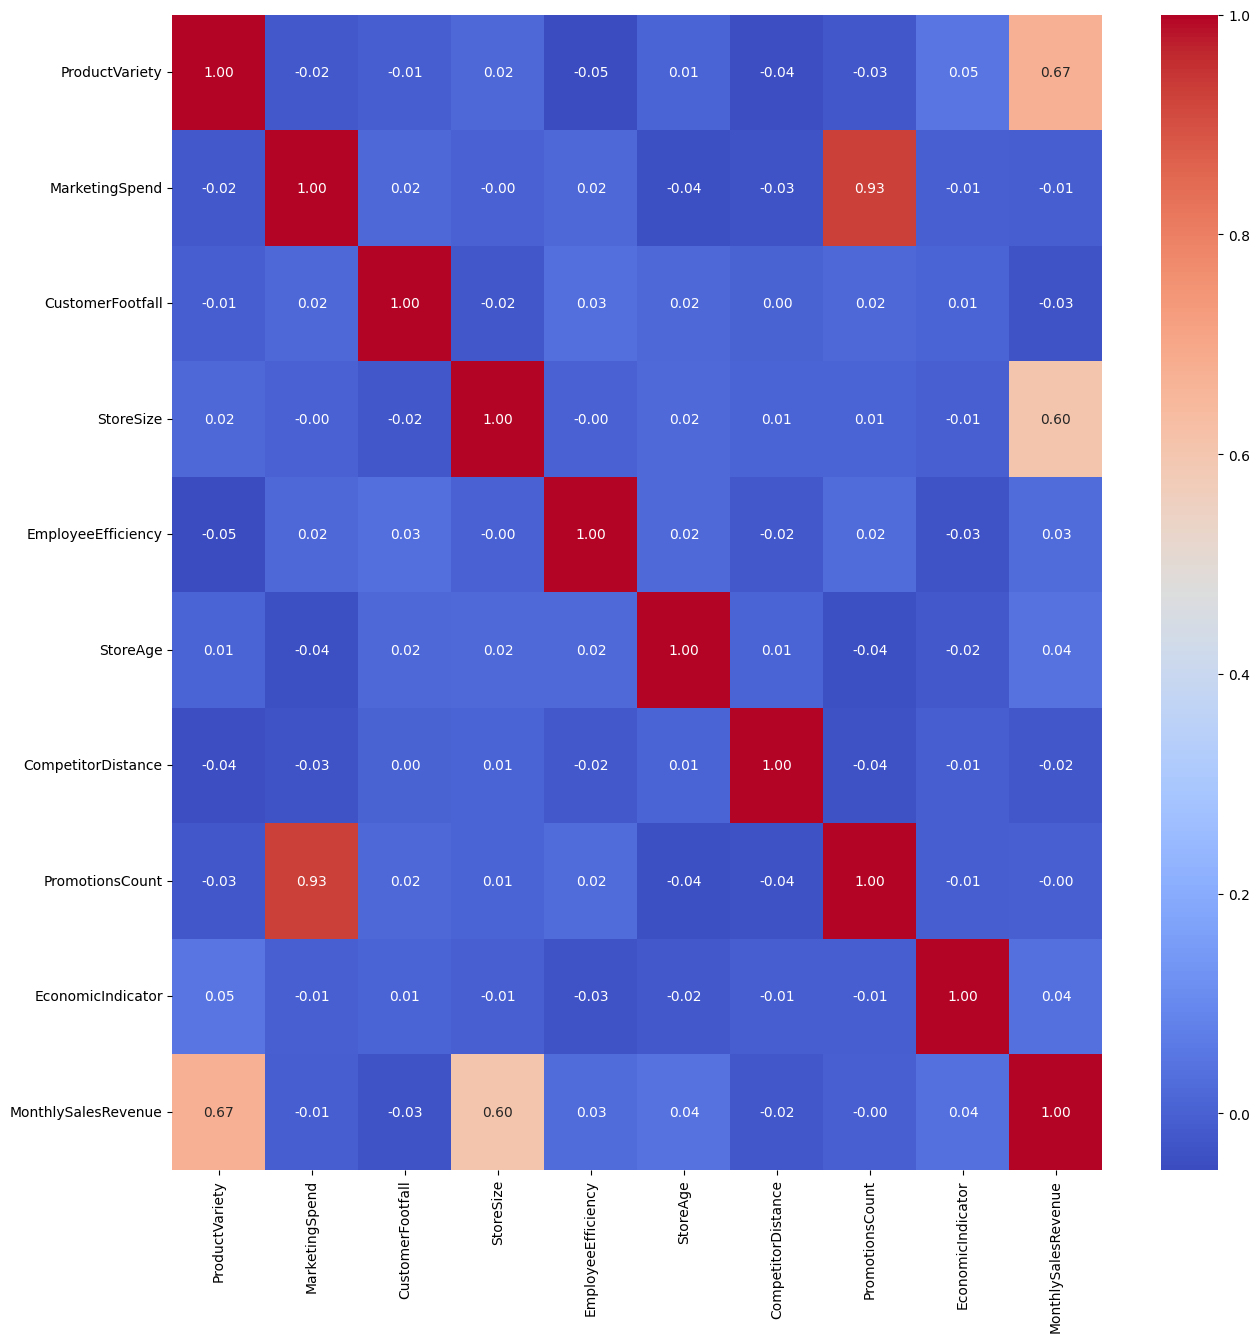

In [5]:
plt.figure(figsize=(15, 15))
sns.heatmap(
    df.select_dtypes(include="number").corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)

In [ ]:
# promtionscount has high correlation with marketingspend

In [9]:
x = df.select_dtypes(include="number").drop("MonthlySalesRevenue", axis=1)
mi_scores = mutual_info_regression(x, df["MonthlySalesRevenue"], random_state=42)
mi_df = pd.DataFrame({
    "Feature": x.columns,
    "MI Score": mi_scores
}).sort_values(by="MI Score", ascending=False)
mi_df

,Feature,MI Score
0,ProductVariety,0.302592
3,StoreSize,0.237085
4,EmployeeEfficiency,0.045294
1,MarketingSpend,0.016429
5,StoreAge,0.015368
2,CustomerFootfall,0.006517
7,PromotionsCount,0.006008
6,CompetitorDistance,0.000000
8,EconomicIndicator,0.000000


In [10]:
df["StoreCategory"].value_counts()

StoreCategory
Grocery        587
Electronics    535
Clothing       528
Name: count, dtype: int64

In [11]:
df["StoreLocation"].value_counts()

StoreLocation
Los Angeles      417
San Francisco    414
Sacramento       412
Palo Alto        407
Name: count, dtype: int64

In [12]:
X = df.drop("MonthlySalesRevenue", axis=1)
y = df["MonthlySalesRevenue"]

In [13]:
for col in X.select_dtypes(include="object").columns:
    X[col] = X[col].astype("category")

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
xgb = XGBRegressor(
    n_estimators=500,
    enable_categorical=True,  
    tree_method="hist", 
    random_state=42
)

In [16]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.7502


In [18]:
num_features = X.select_dtypes(include="number").columns
cat_features = X.select_dtypes(include="object").columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)   

In [19]:
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regressor": SVR(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=300, random_state=42),
    "XGBoost Regressor": XGBRegressor(n_estimators=500, random_state=42)
}

results = []

In [20]:
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "R² Score": r2})
    print(f"{name} R² Score: {r2:.4f}")

Linear Regression R² Score: 0.8125
Support Vector Regressor R² Score: 0.5108
Random Forest Regressor R² Score: 0.7871
XGBoost Regressor R² Score: 0.7422


In [21]:
results_df = pd.DataFrame(results).sort_values(by="R² Score", ascending=False)
results_df

,Model,R² Score
0,Linear Regression,0.812486
2,Random Forest Regressor,0.787082
3,XGBoost Regressor,0.742205
1,Support Vector Regressor,0.510782
